# Code Description
This code takes the large output of a parameter estimation project and then post-processes all of the data

Functions use a standard indexing to refer to our 4 parameters: 0 index is c1, 1 is c2, 2 is T21, and 3 is T22

All parameter sets will be loaded in through the summary file associated with the result files

This code was initially written by Ryan Neff and then continued by Griffin Hampton (GSH) - Mirage Modi played a very important role in the multiprocessing of the data

# Import Packages

In [1]:
#%matplotlib widget
import scipy
import scipy.io
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math
import time
import itertools
from tqdm import trange
from datetime import date
import pickle
import pandas as pd

# Options

In [2]:
#Initial Trial Data is Stored on 17Jan23

data_date_oi = "20Jan23"
series_tag = "SNR_40_subsection_" + data_date_oi

plot_parameter_maps = True


eval_nonReg = True
eval_orc_avg = True
eval_minErr = True
eval_GCV = True


post_normalize_data = True

# Define Parameters

In [3]:
with open('ExperimentalSets/' + series_tag + '/' + 'hprParameter_info_' + data_date_oi + '.pkl', 'rb') as handle:
    dict = pickle.load(handle)
    SNR_goal = dict['SNR_goal']
    n_iterations = dict['n_noise_realizations']
    num_multistarts = dict['num_multistarts']
    lambdas = dict['lambdas']
    tdata = dict['tdata']
    data_file_oi = dict["data_file"]
    data_slice_oi = dict["data_slice"]
    ob_weight = dict['ob_weight']
    upper_bound = dict['upper_bound']
    n_hori = dict['n_horizontal']
    n_vert = dict['n_verticle']
    add_noise, add_mask, apply_normalization, estimate_offset, subsection = dict['options']
    SNR_array = dict['SNR_array']
    handle.close()

n_elements = len(tdata)

agg_weights = np.array([1, 1, 1/ob_weight, 1/ob_weight])

###################### Parameters Loop Through

param_name_list = ['c1','c2','T21','T22']

##################### Important for Naming
date = date.today()
day = date.strftime('%d')
month = date.strftime('%B')[0:3]
year = date.strftime('%y')

# Define General Functions

### Small Helper Functions

In [4]:
########################### Simple Functions ##############################
# Two parameter definition of s(t) with regularization parameter lambda
def G(t, con_1, con_2, tau_1, tau_2): 
    function = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2)
    return function

def G_tilde(lam, SA = 1):
    #SA defines the signal amplitude, defaults to 1 for simulated data
    def Gt_lam(t, con1, con2, tau1, tau2):
        return np.append(G(t, con1, con2, tau1, tau2), [lam*con1/SA, lam*con2/SA, lam*tau1/ob_weight, lam*tau2/ob_weight])
    return Gt_lam

def G_tilde_linear(T21, T22, lam):
    def G_linear(t, c1, c2):
        return np.append(G(t, c1, c2, T21, T22), [lam*c1, lam*c2])
    return G_linear

def construct_paramList(c1_list, T21_list, T22_list):
    preList = [item for item in itertools.product(c1_list, T21_list, T22_list)]
    postList = [list(elem) for elem in preList]
    [elem.insert(1,1-elem[0]) for elem in postList]
    return postList

def J(t, con1, con2, tau1, tau2):
    func1 = np.exp(-t/tau1)
    func2 = np.exp(-t/tau2)
    func3 = (con1*t)*np.exp(-t/tau1)/(tau1**2)
    func4 = (con2*t)*np.exp(-t/tau2)/(tau2**2)
    jacobian = np.stack((func1, func2, func3, func4), axis=-1)
    
    return jacobian

def cov_matrix(con1, con2, tau1, tau2, SNR):
    noise_sd = 1/SNR
    jacobians = J(tdata, con1, con2, tau1, tau2).transpose()@J(tdata, con1, con2, tau1, tau2) 
    covariance = np.linalg.inv(jacobians)
    return (noise_sd**2)*covariance

def check_param_order(popt):
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    if (popt[-1] < popt[-2]): #We want by convention to make sure that T21 is <= T22
        for pi in range(np.size(popt)//2):
            p_hold = popt[2*pi]
            popt[2*pi] = popt[2*pi+1]
            popt[2*pi+1] = p_hold
    return popt

def calc_improvement(old, new):
    return (old - new)/old

def post_normalize(object):
    initial_shape = object.shape
    stacked_params = np.reshape(object, (-1,4))
    scaled_params = np.ones(stacked_params.shape)*np.NAN
    coeficients = stacked_params[:,0]+stacked_params[:,1]
    scaled_params[:,0:2] = stacked_params[:,0:2]/coeficients[:,None]
    scaled_params[:,2:] = stacked_params[:,2:]
    final_obj = np.reshape(scaled_params, initial_shape)
    return final_obj

def to_readable(file):
    df = pd.read_feather(file)
    ALL_ESTIMATES = np.stack(df["Estimates"].values) #shape: (voxel, lambda, popt)
    ALL_RES = np.stack(df["RSS"].values) #shape: (voxel, lambda, RSS val)
    ALL_INDICES = np.stack(df["Indices"].values) #shape: (voxel, lambda, indices)
    ALL_DATA = np.stack(df["Data"].values) #shape: (voxel, lambda, data)
    return ALL_DATA, ALL_INDICES, ALL_ESTIMATES, ALL_RES

### Processing Results Functions

In [5]:
##### Regularization Functions on Stored Data

def pull_avgNR(true_combos, est_combos):
    true_combos = np.array(true_combos)
    bias_hold_array = np.zeros(est_combos.shape)
    for iter in range(bias_hold_array.shape[0]):
        bias_hold_array[iter,:] = est_combos[iter,:] - true_combos[iter, :]
    bias = np.mean(bias_hold_array, axis = 1) #average the bias across all noise realizations
    variance = np.var(est_combos, axis = 1) #obtains the variance across all noise realizations
    return bias, variance

def match_index(index_array, bias, var):
    return_bias = np.zeros(index_array.shape)
    return_var = np.zeros(index_array.shape)
    for iPC in range(index_array.shape[0]):
        if len(index_array.shape)>1:
            for iParam in range(index_array.shape[-1]):
                return_bias[iPC, iParam] = bias[iPC, index_array[iPC, iParam],iParam] 
                return_var[iPC, iParam] = var[iPC, index_array[iPC, iParam],iParam]
        else:
            return_bias[iPC] = bias[iPC, index_array[iPC]] 
            return_var[iPC] = var[iPC, index_array[iPC]]
    return return_bias, return_var


def pull_orc_minErr(true_combos, est_combos):
    true_combos = np.array(true_combos)
    sqError_hold_array = np.zeros(est_combos.shape)
    sqError_agg_hold_array = np.zeros(est_combos.shape[0:-1])
    for iter in range(sqError_hold_array.shape[0]):
        error = np.absolute(est_combos[iter,:] - true_combos[iter, :]) #This absolute value doesn't seem necessary
        sqError_hold_array[iter,:] = (error)**2
        sqError_agg_hold_array[iter,:] = np.sum((agg_weights*error)**2, axis = -1)
    minError_index = np.argmin(sqError_hold_array, axis = -2)
    minError_agg_index = np.argmin(sqError_agg_hold_array, axis = -1)

    return minError_index, minError_agg_index

def match_index_orc2(index_array, params):
    best_indices = index_array.shape
    return_params = np.zeros(np.append(index_array.shape,4))
    for iPC in range(index_array.shape[0]):
        for iNR in range(index_array.shape[1]):
            if len(index_array.shape)>2:
                for iParam in range(index_array.shape[-1]):
                    return_params[iPC, iNR, iParam, :] = params[iPC, iNR, index_array[iPC, iNR, iParam]]
            else:
                return_params[iPC, iNR, :] = params[iPC, iNR, index_array[iPC, iNR]] 
    return return_params

def get_GCV_value(params, RSS, lamb):

    wmat = np.array([[1,0,0,0],[0,1,0,0],[0,0,0.01,0],[0,0,0,0.01]])
    GCVjacobian = J(tdata, *params)
    C_GCV = GCVjacobian@np.linalg.inv(GCVjacobian.transpose()@GCVjacobian+(lamb**2)*wmat.transpose()@wmat)@GCVjacobian.transpose()
    (n,n) = C_GCV.shape
    identity = np.identity(n)
    GCVdenominator = (identity - C_GCV).trace()
    GCV = RSS/(GCVdenominator**2)
    return GCV

def pull_GCV(est_combos, RSS_combos, lambda_array):

    n_vert, n_hori = est_combos.shape[0:2]
    
    GCV_hold_values = np.zeros(len(lambda_array))
    GCV_final_lam = np.zeros((n_vert, n_hori))
    GCV_final_params = np.zeros((n_vert, n_hori, 4))

    for i_vert in range(n_vert): #Loop through all verticle indicies

        for i_hori in range(n_hori):    #Loop through all horizontal indices

            count_singular = 0

            for iLam in range(len(lambda_array)):    #Loop through all lambda values
                one_param_combo = est_combos[i_vert, i_hori, iLam, :]
                one_param_RSS = RSS_combos[i_vert, i_hori, iLam]
                if lambda_array[iLam] == 0:
                    GCV_hold_values[iLam] = np.inf
                else:
                    try:
                        GCV_hold_values[iLam] = get_GCV_value(one_param_combo, one_param_RSS, lambda_array[iLam])
                    except:
                        GCV_hold_values[iLam] = np.inf
                        count_singular += 1

            min_GCV_index = np.argmin(GCV_hold_values)   
            GCV_final_params[i_vert, i_hori,:] = est_combos[i_vert, i_hori, min_GCV_index, :]
            GCV_final_lam[i_vert, i_hori] = lambda_array[min_GCV_index]
            
            if count_singular >0:
                print(f"Combo = [{i_vert}, {i_hori}] had {count_singular} singular GCV values associated with nonzero lambda values")
    
    return GCV_final_lam, GCV_final_params



# Generate Data Sets

In [6]:
all_GCV_estimates = np.zeros((n_iterations, n_vert, n_hori, 4))
all_nonreg_estimates = np.zeros((n_iterations, n_vert, n_hori, 4))
all_data = np.zeros((n_iterations, n_vert, n_hori, n_elements))

In [10]:
for iter in trange(n_iterations):
    data_name = "ExperimentalSets/" + series_tag + "/brainData_" + series_tag + f"_iteration_{iter}.feather"

    print("Retrieving data for " + data_name)
    data, indices, estimates, RSS = to_readable(data_name)

    if post_normalize_data:
        data = post_normalize(estimates)

        grid_size = n_vert*n_hori

    estimates_rs = np.reshape(estimates,(grid_size,52,-1))
    # nonreg_estimates = estimates_rs[:,:,0,:]
    RSS_rs = np.reshape(RSS,(grid_size,52,-1))

    #Removing the extra recordings of the same data
    noiseyDat_rs = np.reshape(data,(grid_size,52,-1))
    noiseyDat_rs = noiseyDat_rs[:,0,:]
#     print(noiseyDat_rs.shape)
    indices_rs = np.reshape(indices,(grid_size,52,-1))
    indices_rs = indices_rs[:,0,:]

    #Initialize properly sized arrays
    ordered_estimates = np.zeros((n_vert, n_hori,52,4))
    ordered_RSS = np.zeros((n_vert, n_hori,52))
    ordered_noiseyDat = np.zeros((n_vert, n_hori, n_elements))

    for iter in range(indices_rs.shape[0]):

        # print(f"Working on horizontal {indices_rs[iter][0]} and verticle {indices_rs[iter][1]}")
        ordered_estimates[indices_rs[iter][0], indices_rs[iter][1],:] = estimates_rs[iter,:]
        ordered_RSS[indices_rs[iter][0], indices_rs[iter][1]] = np.squeeze(RSS_rs[iter,:])
#         ordered_noiseyDat[indices_rs[iter][0], indices_rs[iter][1],:] = noiseyDat_rs[iter,:]

    GCV_lambdas, GCV_estimates = pull_GCV(ordered_estimates, ordered_RSS, lambdas)

    all_nonreg_estimates[iter,:] = ordered_estimates[:,:,0,:]
    all_GCV_estimates[iter,:] = GCV_estimates
#     all_data[iter, :] = ordered_noiseyDat



  0%|                                                                   | 0/6 [00:00<?, ?it/s]

Retrieving data for ExperimentalSets/SNR_40_subsection_20Jan23/brainData_SNR_40_subsection_20Jan23_iteration_0.feather


/tmp/ipykernel_2155601/4153996667.py:56: RuntimeWarning: invalid value encountered in divide
  scaled_params[:,0:2] = stacked_params[:,0:2]/coeficients[:,None]
/tmp/ipykernel_2155601/4153996667.py:25: RuntimeWarning: divide by zero encountered in divide
  func1 = np.exp(-t/tau1)
/tmp/ipykernel_2155601/4153996667.py:26: RuntimeWarning: divide by zero encountered in divide
  func2 = np.exp(-t/tau2)
/tmp/ipykernel_2155601/4153996667.py:27: RuntimeWarning: divide by zero encountered in divide
  func3 = (con1*t)*np.exp(-t/tau1)/(tau1**2)
/tmp/ipykernel_2155601/4153996667.py:27: RuntimeWarning: invalid value encountered in divide
  func3 = (con1*t)*np.exp(-t/tau1)/(tau1**2)
/tmp/ipykernel_2155601/4153996667.py:28: RuntimeWarning: divide by zero encountered in divide
  func4 = (con2*t)*np.exp(-t/tau2)/(tau2**2)
/tmp/ipykernel_2155601/4153996667.py:28: RuntimeWarning: invalid value encountered in divide
  func4 = (con2*t)*np.exp(-t/tau2)/(tau2**2)


(5184, 4)


  0%|                                                                   | 0/6 [00:16<?, ?it/s]


IndexError: index 5183 is out of bounds for axis 0 with size 6

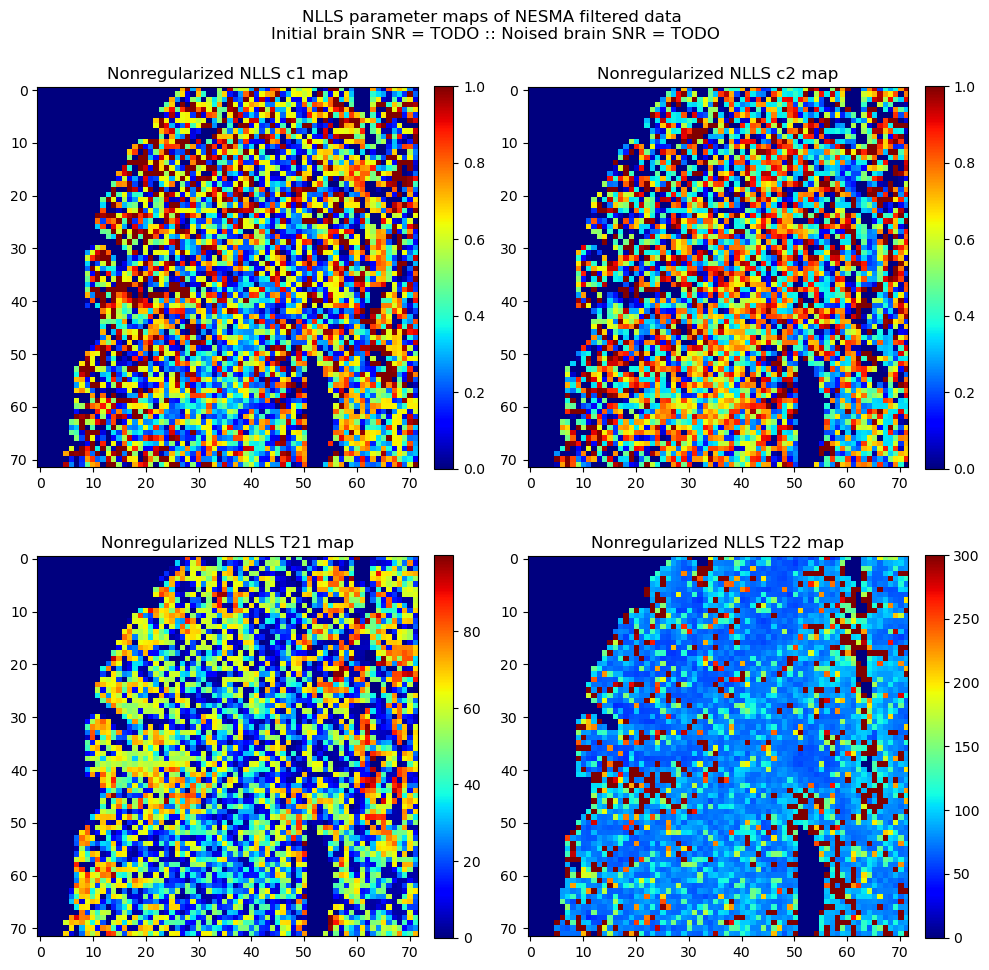

In [13]:
fig, ax = plt.subplots(2,2,figsize=(10,10),tight_layout=True)
fig.suptitle('NLLS parameter maps of NESMA filtered data \nInitial brain SNR = TODO' +  " :: Noised brain SNR = TODO" )
imc1 = ax[0,0].imshow(all_nonreg_estimates[0,:,:,0], cmap = 'jet', vmin=0, vmax=1)
ax[0,0].set_title('Nonregularized NLLS c1 map')

imc2 = ax[0,1].imshow(all_nonreg_estimates[0,:,:,1], cmap = 'jet', vmin=0, vmax=1)
ax[0,1].set_title('Nonregularized NLLS c2 map')

imT21 = ax[1,0].imshow(all_nonreg_estimates[0,:,:,2], cmap = 'jet', vmin=0)
ax[1,0].set_title('Nonregularized NLLS T21 map')

imT22 = ax[1,1].imshow(all_nonreg_estimates[0,:,:,3], cmap = 'jet')
ax[1,1].set_title('Nonregularized NLLS T22 map')

fig.colorbar(imc1, ax=ax[0,0], fraction=0.046, pad=0.04)
fig.colorbar(imc2, ax=ax[0,1], fraction=0.046, pad=0.04)
fig.colorbar(imT21, ax=ax[1,0], fraction=0.046, pad=0.04)
fig.colorbar(imT22, ax=ax[1,1], fraction=0.046, pad=0.04)
plt.show()